In [0]:
import pandas as pd
import numpy as np
import cv2
import scipy
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
os.environ['KAGGLE_CONFIG_DIR'] = "/content/.kaggle"
KAGGLE_CONFIG_DIR='/content/.kaggle'
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [0]:
!kaggle competitions download -c forest-cover-type-prediction
!unzip test.csv.zip
!unzip train.csv.zip

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [0]:
y_train = train.Cover_Type
Id = train.Id
x_train = train.drop(labels=['Id','Cover_Type'], axis=1)

In [6]:
x_train.isnull().values.any() # check for missing values


False

**All features after 10's are categorical in one-hote represent, for this reason we apply StandartScaler only for those feateres.**

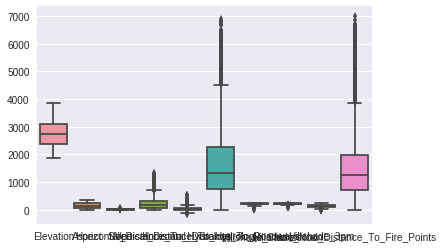

In [7]:
sns.boxplot(x_train.iloc[:,:10]) # Other features are categorical

Before apply StandartScaler

In [0]:
cols = list(x_train.columns.values)[:10]
x_train[cols] = StandardScaler().fit_transform(x_train[cols])


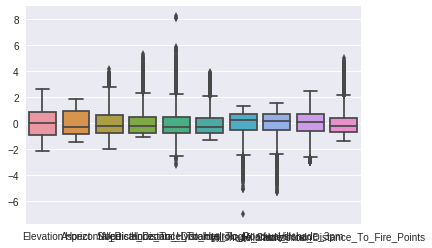

In [9]:
sns.boxplot(x_train.iloc[:,:10])

After apply StandartScaler

Text(0.5, 1.0, 'Correlation between different fearures')

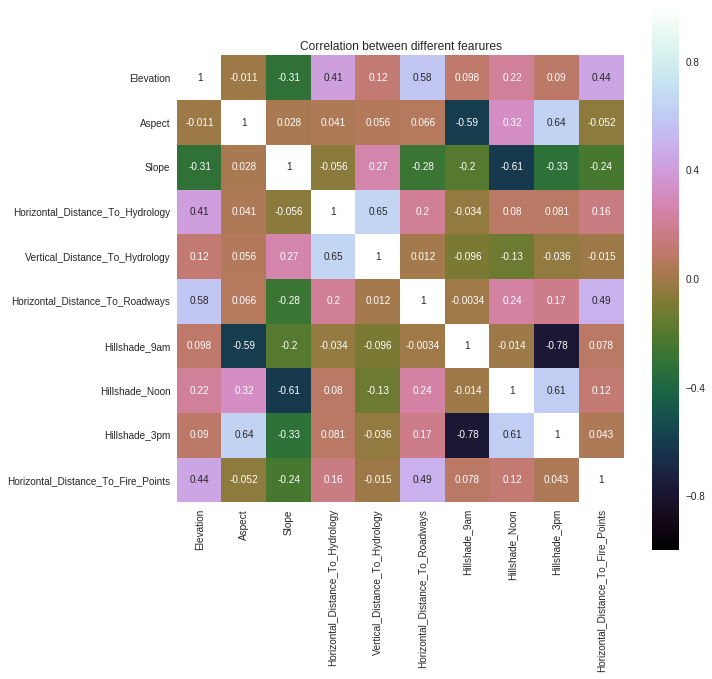

In [10]:
correlation = x_train.iloc[:,:10].corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

plt.title('Correlation between different fearures')

**Some manipulation for PCA**`

In [13]:
cov_mat = np.cov(x_train.iloc[:,:10].T)
cov_mat.shape
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
U, s, V = np.linalg.svd(cov_mat)
print('SVDs: ',s)

SVDs:  [2.8642448  2.28181004 1.82736334 1.05752145 0.54762142 0.47930873
 0.40318906 0.28828625 0.24840362 0.0029127 ]
eigen vals:  [2.8642448  2.28181004 1.82736334 1.05752145 0.0029127  0.24840362
 0.28828625 0.54762142 0.40318906 0.47930873]


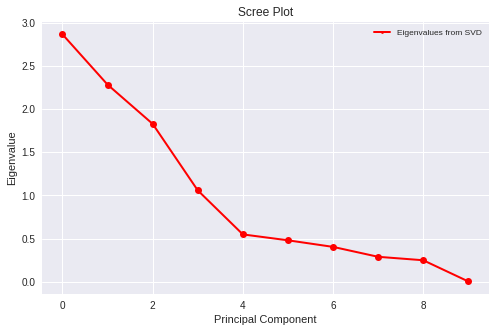

In [20]:
fig = plt.figure(figsize=(8,5))
sing_vals = np.arange(10)
plt.plot(sing_vals, s, 'ro-', linewidth=2)

plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')

leg = plt.legend(['Eigenvalues from SVD'], loc='best', borderpad=0.3, 
                 shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
plt.show()

**"The point where the slope of the curve is clearly leveling off (the “elbow) indicates the number of factors that should be generated by the analysis."**

But I think there is no reason for PCA

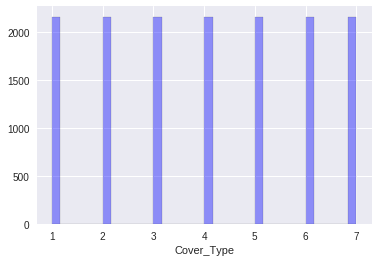

In [21]:
sns.distplot(y_train, hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

In [0]:
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [0]:
param_grid = {'C':[0.1, 1,10],'gamma':[1,0.1], 'kernel':['linear','rbf']}

In [0]:
grid = GridSearchCV(SVC(),param_grid,refit = True, verbose=2)

In [25]:
grid.fit(X_train,y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... C=0.1, gamma=1, kernel=linear, total=   3.9s
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s remaining:    0.0s


[CV] .................... C=0.1, gamma=1, kernel=linear, total=   3.9s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   3.8s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  18.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  18.5s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  18.5s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] .................. C=0.1, gamma=0.1, kernel=linear, total=   3.9s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] .................. C=0.1, gamma=0.1, kernel=linear, total=   3.8s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  7.8min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1], 'kernel': ['linear', 'rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [26]:
grid.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [27]:
print(grid.score(X_train, y_train))
print(grid.score(X_test, y_test))

0.8921957671957672
0.8392857142857143


In [0]:
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.6960978835978836
0.6957671957671958
